# Horizon tracking in 3D

Let's try to implement a horizon tracker, first in 2D then maybe 3D...

The seismic data is from Penobscot: https://terranubis.com/datainfo/Penobscot

But really you could use any 3D seismic.

## Load some seismic

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import segyio

with segyio.open('../data/Penobscot_0-1000ms.sgy') as s:
    seismic = segyio.cube(s)[::2]
    
seismic.shape

(301, 481, 251)

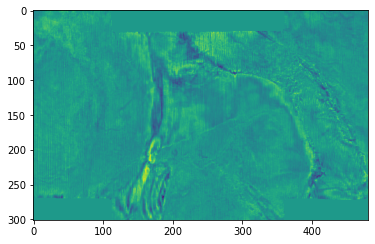

In [4]:
plt.imshow(seismic[:, :, 100])

Let's make a quick mask so we can easily cut away the non-data areas.

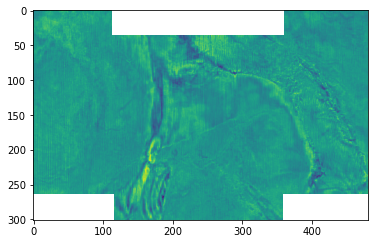

In [16]:
mask = np.ones(seismic.shape[:2])
mask[:35, 115:360] = np.nan
mask[265:, :115] = np.nan
mask[265:, 360:] = np.nan

plt.imshow((mask[:, :, None] * seismic)[:, :, 100])

Let's check the distribution of amplitudes.

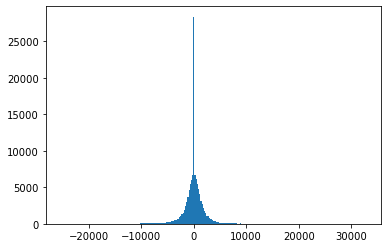

In [5]:
_ = plt.hist(seismic[100].ravel(), bins=256)
plt.yscale('log')

## Regularize & bit-reduce seismic

Sometimes we'll run into memory issues.One way to deal with this is to reduce the bit-depth of the data.

### EXERCISE

Write a function to change the data to 8-bit integers, losing as little dynamic range as possible.

You'll need to clip the data's tails, perhaps asking the user for a percentile to clip to. Then scale the data, put it in the range ±127, and cast to NumPy's `int8` dtype.

Call the new volume `seismic8`.

In [ ]:
# YOUR CODE HERE



In [2]:
def bit_reduce(data, clip_perc=99):
    """
    Reduce bit depth to 8-bit signed int.
    """
    amax = np.percentile(abs(data), clip_perc)
    data = np.clip(data, -amax, amax)
    data = 127 * data / amax
    print(amax)
    print(np.nanmax(data), np.nanmin(data))
    return data.astype(np.int8)

seismic8 = bit_reduce(seismic)

plt.figure(figsize=(15, 3))
_ = plt.hist(seismic8[::10].ravel(), bins=255)
plt.yscale('log')

NameError: name 'seismic' is not defined

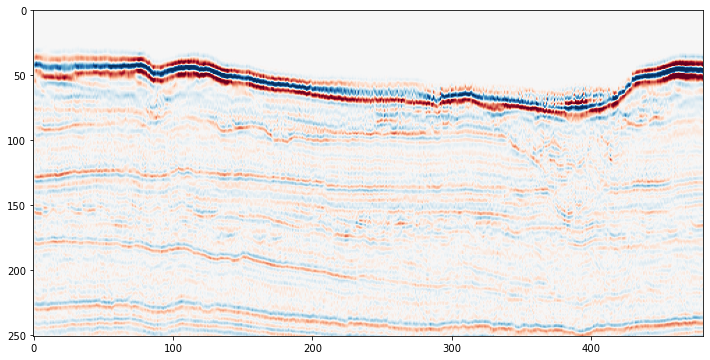

In [7]:
plt.figure(figsize=(12, 6))
plt.imshow(seismic8[100].T, aspect='auto', cmap='RdBu')

Here's a trick to modify a matplotlib colormap so you can see clipped data at the ends:

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

rdbu = cm.get_cmap('RdBu', 256)

newcolors = rdbu(np.linspace(0, 1, 256))

yellow  = np.array([ 1, 1, 0, 1])
cyan = np.array([ 0, 1, 1, 1])

newcolors[:2, :] = yellow
newcolors[-2:, :] = cyan

newcmp = ListedColormap(newcolors)

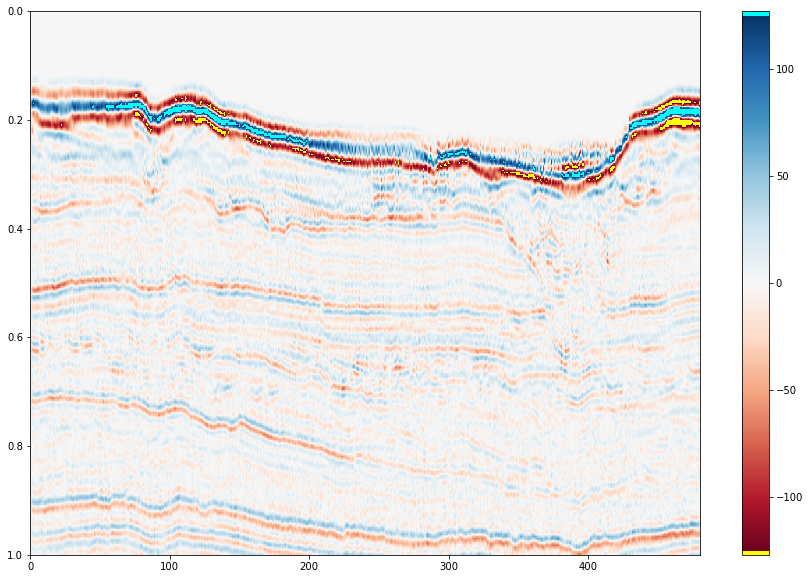

In [9]:
plt.figure(figsize=(15, 10))
plt.imshow(seismic8[100].T, aspect='auto', cmap=newcmp, extent=(0, 480, 1.0, 0), vmin=-127, vmax=127)
plt.colorbar()

## Naive picking method

### EXERCISE

Can you think of a quick way to auto-pick the sea-floor? <a title="np.argmax() could be useful."><b>Hover for HINT</b></a> 

Plot it on the seismic section.

In [17]:
# Naive method, use argmax
sf_idx_naive = np.argmax(seismic[:, :, :80], axis=-1)
sf_naive = sf_idx_naive * 0.0040
sf_naive *= mask

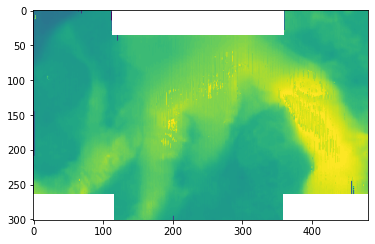

In [18]:
plt.imshow(sf_naive)

(0.5, 0.0)

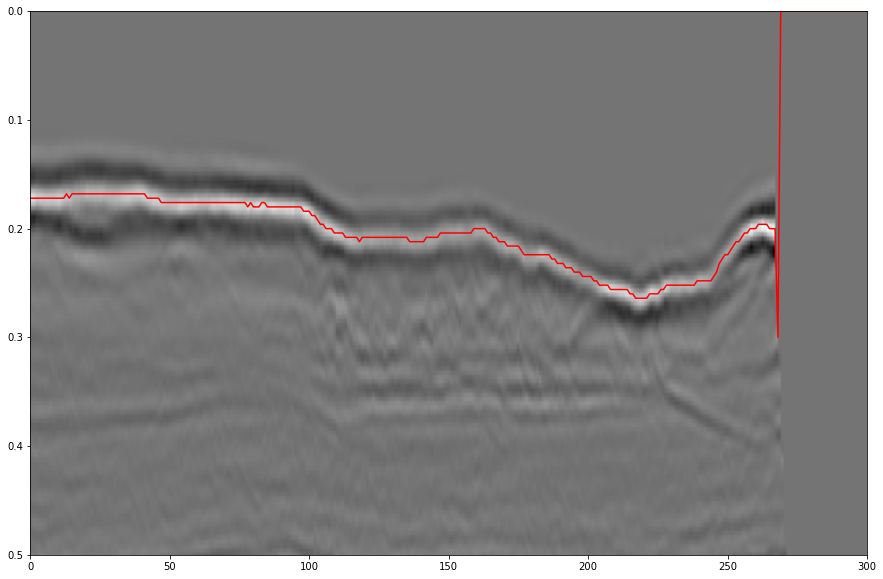

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow(seismic[:, 100].T, aspect='auto', cmap='gray', extent=(0, 300, 1.0, 0))
plt.plot(sf_naive[:, 100], 'r-')
plt.ylim(0.5, 0)

Notice that the result is discrete — it can only take index values, i.e. integer multiples of 4 ms.

You could smooth it, but it's probably better to try to pick the position of the actual peak, given a continuous trace. A fast way to do this is to assume a parabolic shape, which then has an analytic solution for a zero derivative.

## Parabolic interpolation

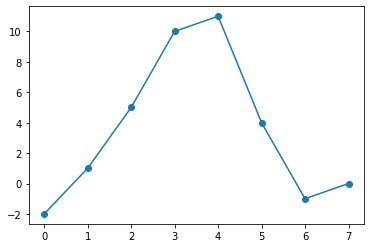

In [9]:
data = [-2, 1, 5, 10, 11, 4, -1, 0]

plt.plot(data, 'o-')

In [10]:
from welly.utils import parabolic

parabolic(data, np.argmax(data))

(3.625, 11.5625)

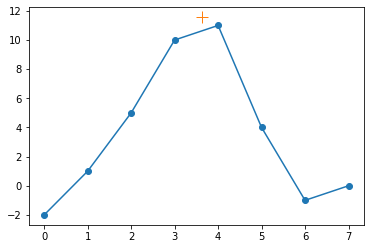

In [11]:
idx, max_ = parabolic(data, np.argmax(data))

plt.plot(data, 'o-')
plt.plot(idx, max_, '+', ms=12)

### EXERCISE

Can you write a function to get the parabolic peak from a trace, then apply that to a line — or the whole volume! — using `np.apply_along_axis()`?

In [ ]:
# YOUR CODE HERE



In [19]:
def get_max_time(trace):
    argmax = np.argmax(trace)
    if np.isnan(argmax) or (argmax >= trace.size - 1):
        return np.nan
    t_max, a_max = parabolic(trace, argmax)
    return t_max

sf_idx = np.array([np.apply_along_axis(get_max_time, axis=1, arr=line) for line in seismic])
sf = sf_idx * 0.0040
sf *= mask

/Users/matt/opt/miniconda3/envs/geoph/lib/python3.8/site-packages/welly/utils.py:255: RuntimeWarning: invalid value encountered in double_scalars
  xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x


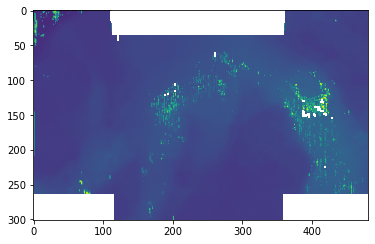

In [20]:
plt.imshow(sf)

(0.5, 0.0)

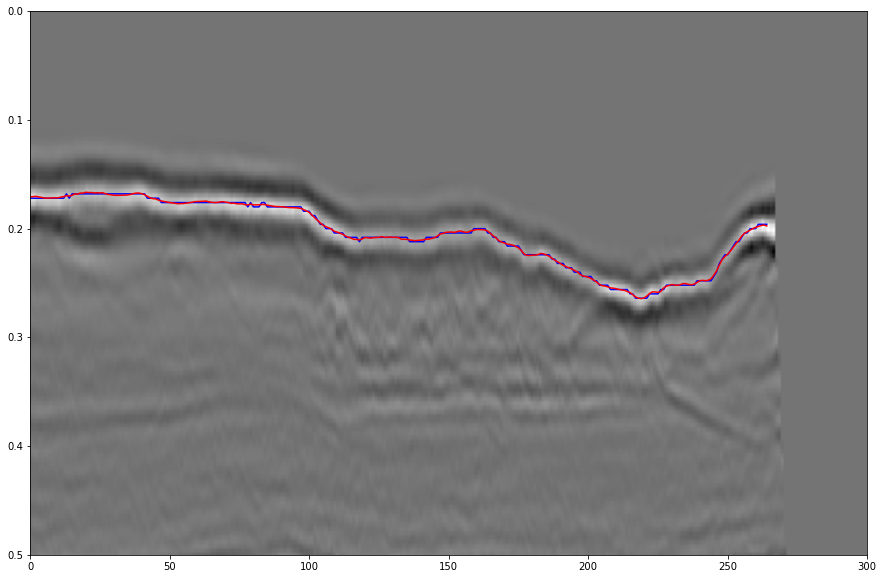

In [22]:
plt.figure(figsize=(15, 10))
plt.imshow(seismic[:, 100].T, aspect='auto', cmap='gray', extent=(0, 301, 1.0, 0))
plt.plot(sf_naive[:, 100], 'b-')
plt.plot(sf[:, 100], 'r-')
plt.ylim(0.5, 0)

## Amplitude extraction

### EXERCISE

Extract the amplitude from the seismic onto the horizon, and plot that in a new matplotlib axes (aka subplot), above the seismic section.

In [18]:
# YOUR CODE HERE



In [23]:
# Tempting to try:
#   amp = seismic[:, sf_idx]

# But you need to tell NumPy which to take from each axis:
x, i, _ = map(np.arange, seismic.shape)
amp = np.array([line[i, sf_idx_naive[x]] for x, line in enumerate(seismic)])

amp.shape

(301, 481)

In [24]:
# Or we can get it from the parabolic interpolation function:
def get_max_amp(trace):
    argmax = np.argmax(trace)
    if np.isnan(argmax) or (argmax >= trace.size - 1):
        return np.nan
    t_max, a_max = parabolic(trace, argmax)
    return a_max

amp_interpolated = np.array([np.apply_along_axis(get_max_amp, axis=1, arr=line) for line in seismic])

/Users/matt/opt/miniconda3/envs/geoph/lib/python3.8/site-packages/welly/utils.py:255: RuntimeWarning: invalid value encountered in double_scalars
  xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x


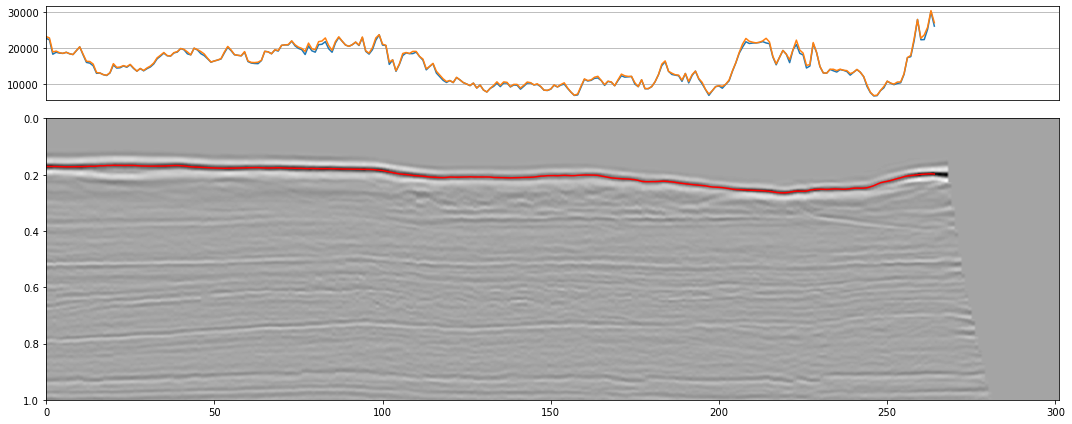

In [26]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 3]})
axs[0].plot(amp[:, 100]) # Blue.
axs[0].plot(amp_interpolated[:, 100]) # Orange.
axs[0].set_xlim(0, 301)
axs[0].set_xticks([])
axs[0].grid()
axs[1].imshow(seismic[:, 100].T, cmap='Greys', extent=(0, 301, 1.0, 0), aspect='auto')
axs[1].set_ylim(1, 0)
axs[1].plot(sf[:, 100], 'r')
plt.tight_layout()
plt.show()

## `xarray`

Another option is to use `xarray`.

### EXERCISE

Make a `DataArray` for the seismic volume. Call it `seismic_`.

Try making one for the horizon too. Call it `sf_`.

In [22]:
# YOUR CODE HERE



In [27]:
import xarray as xr

x, i, t = map(np.arange, seismic.shape)

seismic_ = xr.DataArray(seismic,
                        name='amplitude',
                        coords=[x, i, t*0.004],
                        dims=['xline', 'inline', 'twt']
                       )

sf_ = xr.DataArray(sf,
                   name='twt',
                   coords=[x, i],
                   dims=['xline', 'inline'],
                  )

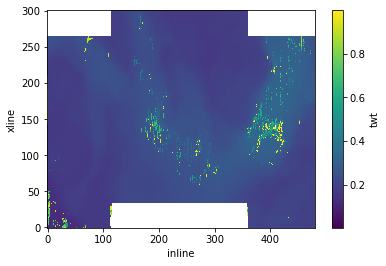

In [28]:
sf_.plot()

Now we can easily slice into the seismic volume using the horizon. We get linear interpolation for free!

In [26]:
amp_ = seismic_.interp(xline=sf_.xline, inline=sf_.inline, twt=sf_, method='linear')

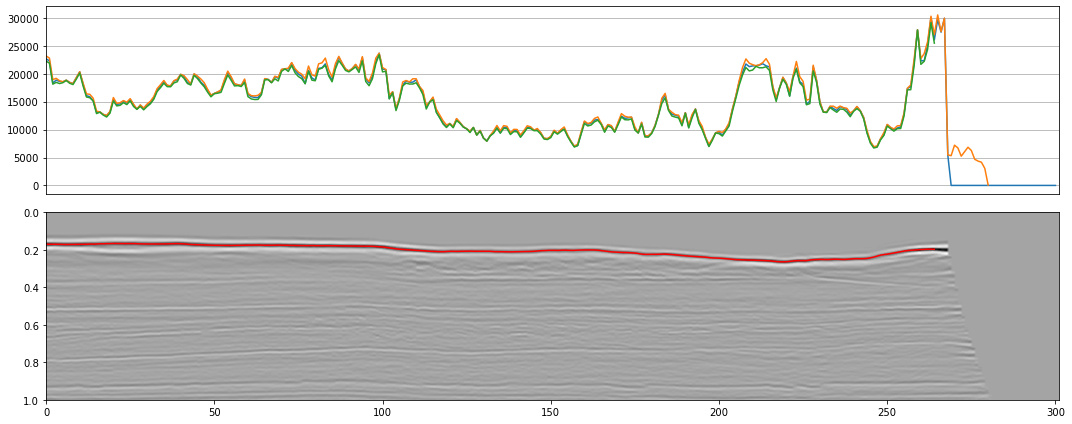

In [30]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 1]})

axs[0].plot(amp[:, 100])
axs[0].plot(amp_interpolated[:, 100]) # Orange.
axs[0].plot(amp_[:, 100]) # Green.
axs[0].set_xlim(0, 301)
axs[0].set_xticks([])
axs[0].grid()

axs[1].imshow(seismic[:, 100].T, cmap='Greys', extent=(0, 301, 1.0, 0), aspect='auto')
axs[1].set_ylim(1, 0)
axs[1].plot(sf[:, 100], 'r')

plt.tight_layout()
plt.show()

## Dynamic time warping

In [29]:
trace1 = np.array([0, 1, 2, 6, 3, 1, -1, 0])
trace2 = np.array([0, -1, 1, 2, 3, 10, 4, 3, 1, 1])

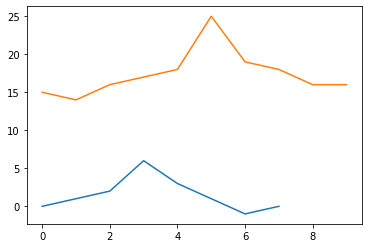

In [30]:
plt.plot(trace1)
plt.plot(trace2 + 15)

There is another pure Python implementation here: https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd. It might be nice to know about because it has a 'window' parameter, so you don't have to try every lag. It's generally slower, but faster for short windows.

There are also several Cython (therefore fast) implementations, which may or may not compile for you...

- [`tslearn`](https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html)
- PyDTW
- dtw-python
- dtw

In [1]:
from tslearn.metrics import dtw_path

path, _ = dtw_path(trace1, trace2)

/Users/matt/opt/miniconda3/envs/geoph/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


NameError: name 'trace1' is not defined

In [32]:
path

[(0, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (2, 4),
 (3, 5),
 (4, 6),
 (4, 7),
 (5, 8),
 (6, 8),
 (7, 9)]

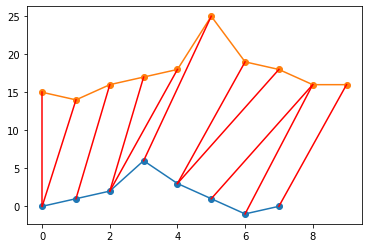

In [33]:
plt.plot(trace1, 'o-')
plt.plot(trace2+15, 'o-')
for (i, j) in path:
    plt.plot(*[(i, j), (trace1[i], trace2[j]+15)], 'r-')

## Pick the sea floor

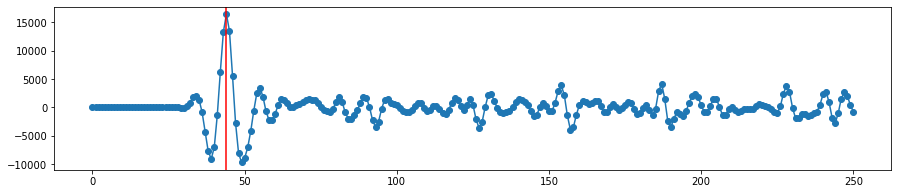

In [34]:
plt.figure(figsize=(15, 3))
plt.plot(seismic[50, 100], "o-")
plt.axvline(44, c='r')

In [35]:
def parabolic(f, x):
    """
    Parabolic interpolation finds the approximate position and value
    of the local maximum on a curve, given the position of the closest
    peak, eg with argmax().
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - (1/4) * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

In [36]:
def pick_next(seed, tr1, tr2, gate=10, pref='down'):
    """
    Given a seed position (in index space) and two traces,
    propagate the position from the first to the second.
    """
    if np.isnan(seed): return np.nan
    seed_idx = round(seed)
    s1 = tr1[seed_idx-gate:seed_idx+gate]
    s2 = tr2[seed_idx-gate:seed_idx+gate]
    path, _ = dtw_path(s1, s2)
    path = np.array(path)
    candidates = path[path[:, 0]==gate][:, 1]
    if pref == 'up':
        idx_ = 0
    elif pref == 'down':
        idx_ = -1
    else:
        idx_ = len(candidates) // 2
    idx = seed_idx + candidates[idx_] - gate
    t_max, _ = parabolic(tr2, idx)
    return t_max

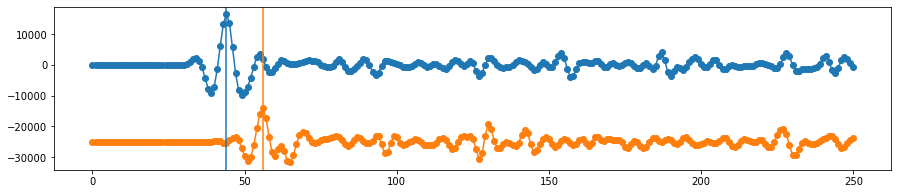

In [37]:
plt.figure(figsize=(15, 3))
seed, _ = parabolic(seismic[50, 100], 44)
plt.plot(seismic[50, 100], 'o-')
plt.plot(seismic[250, 100]-25000, 'o-')
seed_ = pick_next(seed, seismic[50, 100], seismic[250, 100], gate=20)
plt.plot(seed_)
plt.axvline(seed, c='C0')
plt.axvline(seed_, c='C1')

In [ ]:
np.where(~np.isnan(mask))[0].size, ~np.isnan(mask).size

In [ ]:
def make_picks(seismic, seed, gate=10):
    """
    Given a seismic volume and a seed, make the best pick.
    """
    live = ~np.isnan(mask).size
    picks = {seed[0]: {'parent': None, 'index': seed[1]}}
    xls, ils, ts = seismic.shape
    while len(picks) < 0.25*live:
        new_picks = {}
        for (xl, il), meta in picks.items():
            if not meta:
                continue
            idx = meta['index']
            this = seismic[xl, il]
            if ((xl - 1, il) not in picks) and (xl - 1 >= 0):
                that = seismic[xl - 1, il]
                new_picks[xl - 1, il] = {'parent': (xl, il), 'index': pick_next(idx, this, that, gate=gate)}
            if ((xl, il - 1) not in picks) and (il - 1 >= 0):
                that = seismic[xl, il - 1]
                new_picks[xl, il - 1] = {'parent': (xl, il), 'index': pick_next(idx, this, that, gate=gate)}
            if ((xl + 1, il) not in picks) and (xl + 1 < xls):
                that = seismic[xl + 1, il]
                new_picks[xl + 1, il] = {'parent': (xl, il), 'index': pick_next(idx, this, that, gate=gate)}
            if ((xl, il + 1) not in picks) and (il + 1 < ils):
                that = seismic[xl, il + 1]
                new_picks[xl, il + 1] = {'parent': (xl, il), 'index': pick_next(idx, this, that, gate=gate)}
        picks.update(new_picks)  
    return picks

picks = make_picks(seismic, ((50, 100), seed))

<ipython-input-35-4f5b14db638e>:7: RuntimeWarning: invalid value encountered in double_scalars
  xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
<ipython-input-35-4f5b14db638e>:7: RuntimeWarning: divide by zero encountered in double_scalars
  xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x


In [40]:
sf = np.zeros(seismic.shape[:2]) * np.nan
for (x, i), meta in picks.items():
    sf[x, i] = meta['index']

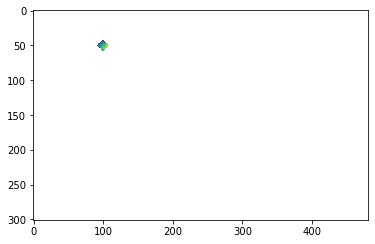

In [41]:
plt.imshow(sf)

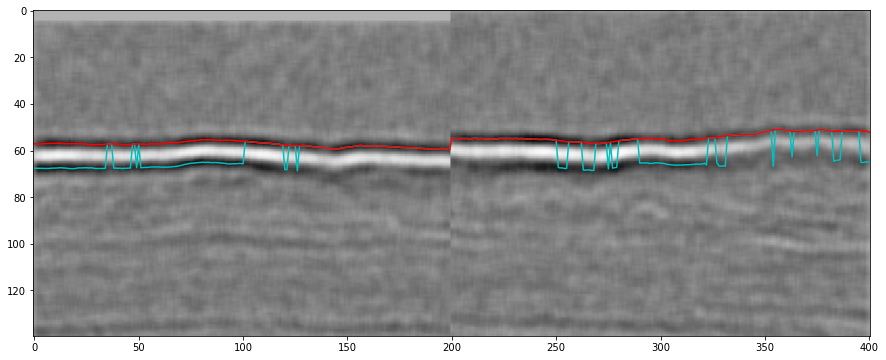

In [35]:
plt.figure(figsize=(15, 6))
plt.imshow(seismic.T[:140], cmap='Greys', aspect='auto')
plt.plot(sf_idx, 'c-')
plt.plot(sf, 'r-')

## Save the best one

In [1]:
np.save('../data/Penobscot_seabed_auto.npy', sf_)

NameError: name 'sf_' is not defined

## Correlation

Let's use correlation instead of the DTW propagator.

## Picking geobody instead

We should be able to use the same seed propagator, but switch out the `pick_next()` function.

## More seismic

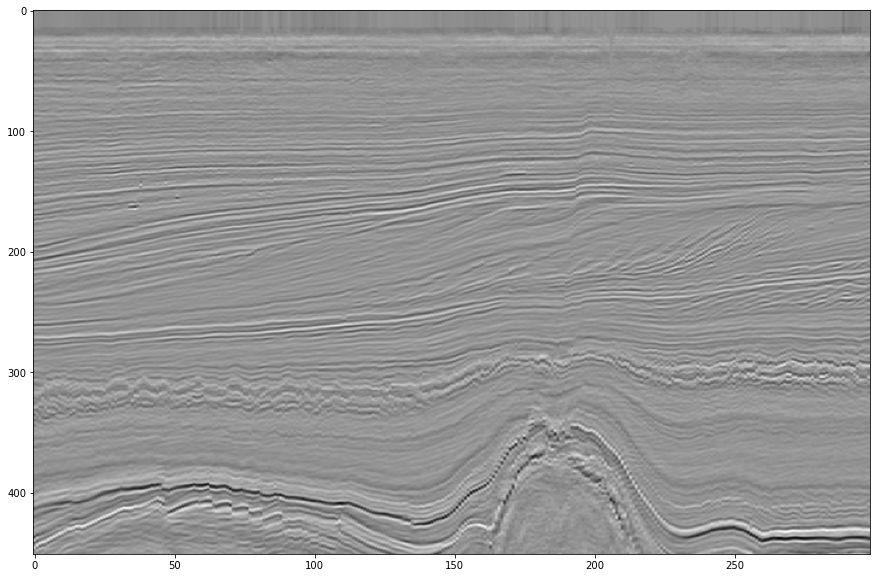

In [60]:
seismic = np.load('../data/F3_volume_3x3_16bit.npy')

plt.figure(figsize=(15, 10))
plt.imshow(seismic[80].T, aspect='auto', cmap='gray')

## More seismic still

This one is from https://github.com/ajbugge/HorizonTracker

In [36]:
data = np.load('../data/seismic_volume.npy')
data.shape

(155, 100, 400)

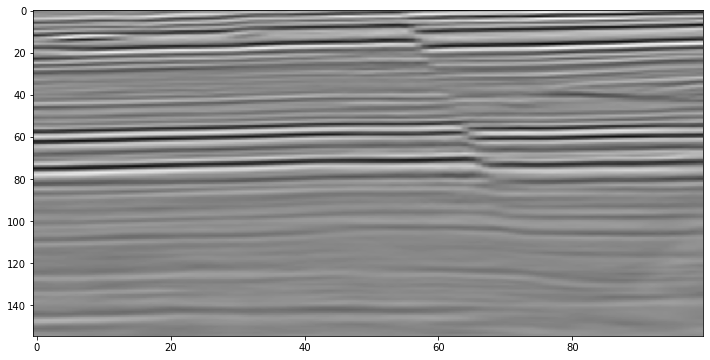

In [37]:
section = data[:, :, 280]

plt.figure(figsize=(12, 6))
plt.imshow(section, cmap='gray', aspect='auto')

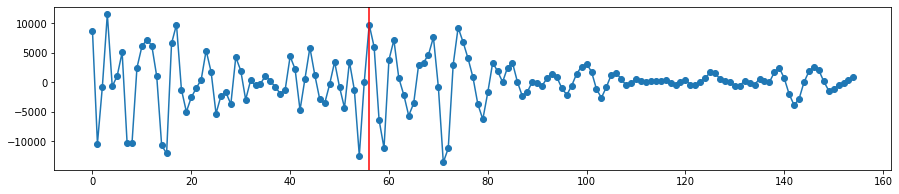

In [38]:
t = 56

plt.figure(figsize=(15, 3))
plt.plot(section[:, 50], 'C0o-')
plt.axvline(t, c='r')

In [39]:
seed_t, _ = parabolic(section[:, 50], t)
seed = (50, seed_t)
picks = make_picks(section.T, seed, gate=10)

In [40]:
hrz = [meta['index'] for (tr, meta) in sorted(picks.items(), key=lambda x: x[0])]

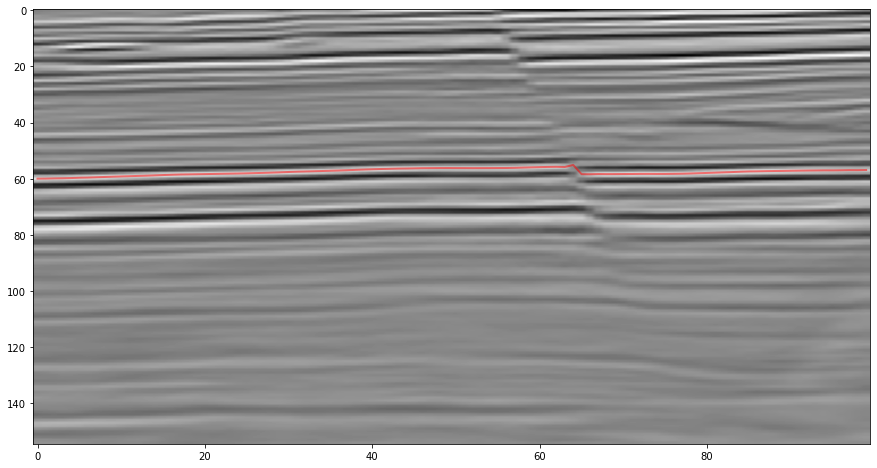

In [41]:
plt.figure(figsize=(15, 8))
plt.imshow(section, cmap='gray', aspect='auto')
plt.plot(hrz, 'r-', lw=2, alpha=0.5)

Next...

- Make a way to measure the confidence of the pick. Then in 3D we will be able to make the best picks first, only trying harder ones later. You could measure a correlation coefficient, or maybe use the DTW cost matrix.
- Implement in 3D. The method we have here should already allow a person to use multiple seeds.
- Make a `matplotlib` listener to allow you to pick the seed from a mouse-click on a plot.

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2021</p>
</div>